In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense, Conv1D, MaxPooling1D, Dropout
from keras.models import Model

In [19]:
def word_split(mystring):
    str_split = []
    for tmp in mystring:
        tmp = re.sub('[^a-zA-Z0-9\s]+', '', tmp)
        tmp = tmp.split(' ')
        while True:
            if '' not in tmp:
                break
            tmp.remove('')    
        str_split.append(tmp)
    return str_split

In [20]:
all_data = pd.read_csv("train.csv")
data = all_data['Headline']
label = all_data['Label']

In [21]:
my_split = word_split(data)

In [22]:
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [23]:
tokenizer.fit_on_texts(my_split)

In [24]:
x= tokenizer.texts_to_sequences(my_split)
max_seq_len = max([len(seq) for seq in x])
MAX_SEQUENCE_LENGTH = 20
x = keras.preprocessing.sequence.pad_sequences(x,maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.2, random_state = 42)

In [29]:
input_ = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')


# 詞嵌入層
# 經過詞嵌入層的轉換，兩個新聞標題都變成
# 一個詞向量的序列，而每個詞向量的維度
# 為 256
embedding_layer = Embedding(
    MAX_NUM_WORDS, 128)
embedded = embedding_layer(
    input_)
# LSTM 層
# 兩個新聞標題經過此層後
# 為一個 128 維度向量
lstm = LSTM(128)
output =lstm(embedded)

# 串接層將兩個新聞標題的結果串接單一向量
# 方便跟全連結層相連

dense =  Dense(
    units=1, 
    activation='linear')
predictions = dense(output)
# 我們的模型就是將數字序列的輸入，轉換
# 成 3 個分類的機率的所有步驟 / 層的總和
model = Model(
    inputs=input_, 
    outputs=predictions)
model.compile(
    optimizer='sgd',
    loss='mean_squared_error',
    metrics=['accuracy'])
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test), batch_size=32,epochs=20,shuffle=True)

Epoch 1/20
51/51 [==============================] - 1s 14ms/step - loss: 1.5395 - val_loss: 0.5427
Epoch 2/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5369 - val_loss: 0.5395
Epoch 3/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5332 - val_loss: 0.5376
Epoch 4/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5356 - val_loss: 0.5382
Epoch 5/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5395 - val_loss: 0.5457
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5337 - val_loss: 0.5732
Epoch 7/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5348 - val_loss: 0.5521
Epoch 8/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5332 - val_loss: 0.5416
Epoch 9/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5341 - val_loss: 0.5675
Epoch 10/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5361 - val_loss: 0.5417
Epoch 11/20
51/51 

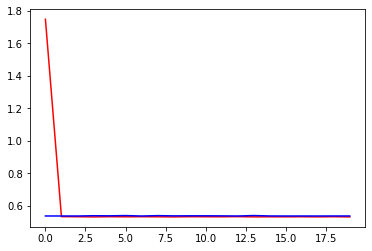

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'r', val_loss, 'b')

In [309]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline'].to_numpy()
label = test_data['Label'].to_numpy()
my_split = word_split(data)

In [294]:
x= tokenizer.texts_to_sequences(my_split)
x = keras.preprocessing.sequence.pad_sequences(x,maxlen=MAX_SEQUENCE_LENGTH)

In [295]:
y_pre = model.predict(x)
b = np.arange(1, y_pre.shape[0]+1, dtype='int32').reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

In [296]:
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID','Label'])
    writer.writerows(y_pre)